# Test with VOC Dataset

THE VOC dataset from years 2007 and 2012 contains 20 classes (+1 for background class)

We will experiment with this for object detection and would be working with another dataset later on.


### Contains Functions:

- parse_annotations: Takes in annotation path for the images and creates, boxes, labels and difficulties lists so that when we create a json file, we have the lists going in
- Create Data Lists: Takes in the path for train and test data and using parse_annotations, extracts the lists from the .xml files and creates json files with train_images and train_objects where the objects have data from the parse_annotations functions' extraction of the .xml files about the objects
- Transform: BIG ONE. Uses multiple functions like expand, resize, flip, random_crop and photometric distort:
    - Expand: Expands the image size with a random prob of 0.5. Creates a new images and super imposes our image onto it. Important because the boxes sizes for the objects would need to be adjusted as well
    - Resize: Resizes the image as well as the bounding boxes' dimensions. Could keep the same dimensions if the dimensions are the percent of the width and height because then we can just find object coordinates by multiplying the % with new_dims
    - Flip: Flips the image horizontally and need to adjust the object bounding boxes the same way
    - photometric distort: Randomly distorts the photographs by changing the saturation, hue, contrast.
    - Random_crop: 


In [1]:
import torch
from torch.utils.data import Dataset
import json
import os
from PIL import Image
# from utils import transform
import torchvision.transforms.functional as FT
import xml.etree.ElementTree as ET

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

voc_labels = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
              'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')


label_map = {k: v+1 for v, k in enumerate(voc_labels)}
label_map['background'] = 0
rev_color_map = {v: k for k, v in label_map.items()}

In [91]:
distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4', '#46f0f0', '#f032e6',
                   '#d2f53c', '#fabebe', '#008080', '#000080', '#aa6e28', '#fffac8', '#800000', '#aaffc3', '#808000',
                   '#ffd8b1', '#e6beff', '#808080', '#FFFFFF']
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_map.keys())}

label_color_map

{'aeroplane': '#e6194b',
 'bicycle': '#3cb44b',
 'bird': '#ffe119',
 'boat': '#0082c8',
 'bottle': '#f58231',
 'bus': '#911eb4',
 'car': '#46f0f0',
 'cat': '#f032e6',
 'chair': '#d2f53c',
 'cow': '#fabebe',
 'diningtable': '#008080',
 'dog': '#000080',
 'horse': '#aa6e28',
 'motorbike': '#fffac8',
 'person': '#800000',
 'pottedplant': '#aaffc3',
 'sheep': '#808000',
 'sofa': '#ffd8b1',
 'train': '#e6beff',
 'tvmonitor': '#808080',
 'background': '#FFFFFF'}

Parse Annotation function is called inside another function and is passed in an annotation path.
It takes the path and extracts the tree structure ( path is assumed to link to xml file)
It gets a root from the tree and iterates through the items in the xml file by getting the object, finding if it has difficult in it and assigning it a value 1?
find the label and lowers the name of the object
finds the bounding box 4 values and subtract 1 from them (why?)
Then we append the output boxes, labels, difficulties in a list.

Parses annotations mostly

In [4]:
def parse_annotation(annotation_path):
    
    # Xml is an inherently hierarchical data format, and mostly represented with a  tree.
    # Element tree is the whole XML document  as a tree and Element is a single node in the tree
    
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    
    boxes = list()
    labels = list()
    difficulties = list()    # the boxes/objects that were super difficult to detect by the model
    
    for object in root.iter('object'):
        
        difficult = int(object.find('difficult').text == '1')
        
        label = object.find('name').text.lower().strip()
        
        if label not in label_map:
            continue
            
        bbox = object.find('bndbox')
        xmin = int(bbox.find('xmin').text) - 1
        ymin = int(bbox.find('ymin').text) - 1
        xmax = int(bbox.find('xmax').text) - 1
        ymax = int(bbox.find('ymax').text) - 1
        
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label_map[label])
        difficulties.append(difficult)
    
    return {'boxes': boxes, 'labels': labels, 'difficulties': difficulties}
        

For objects, we get the difficulties, labels and boxes and return them as lists using the parse_annotations function.
We take those objects from the files that we pass in and apend them to train_objects list i.e. nested list or dictionary. Now the length of the list should be the same as the train_images list because each key in the train_objects list would have multiple values for boxes, labels and difficulties

In [5]:
def create_data_lists(voc07_path, voc12_path, output_folder):
    """
    Create lists of images, bounding boxes, labels of the objects in these images,
    and save them to file.
    
    :param voc07_path: path to the 'VOC2007' folder
    :param voc12_path: path to the 'VOC2012' folder
    :param output_folder: folder where the JSONs must be saved
    """
    voc07_path = os.path.abspath(voc07_path)
    voc12_path = os.path.abspath(voc12_path)
    
    train_images = list()
    train_objects = list()
    n_objects = 0
    
    
    # load the training data
    
    for path in [voc07_path, voc12_path]:
        
        with open(os.path.join(path, 'ImageSets/Main/trainval.txt')) as f:
            ids = f.read().splitlines()
            
        for id in ids:
            objects = parse_annotation(os.path.join(path, 'Annotations', id +'.xml'))   # Just transforms the read in xml file a little bit
            if len(objects) == 0:
                continue
            
            n_objects += len(objects)
            train_objects.append(objects)  # is this creating an appended list or dictionary?
            train_images.append(os.path.join(path, 'JPEGImages', id + '.jpg'))
         # train objects contains the dictionary of all the objects in a single image
        # 
    assert len(train_objects) == len(train_images)
    
    # save them to a JSON file
    with open(os.path.join(output_folder, 'TRAIN_images.json'), 'w') as j:
        json.dump(train_images, j)
        
    with open(os.path.join(output_folder, 'TRAIN_objects.json'), 'w') as j:
        json.dump(train_objects, j)
    
    with open(os.path.join(output_folder, 'label_map.json'), 'w')as j:
        json.dump(label_map, j)
        
    print('\nThere are %d training images containing a total of %d objects. Files have been saved to %s.' % (
        len(train_images), n_objects, os.path.abspath(output_folder)))

    # Test data
    
    test_images = list()
    test_objects = list()
    n_objects = 0

    # Find IDs of images in the test data
    with open(os.path.join(voc07_path, 'ImageSets/Main/test.txt')) as f:
        ids = f.read().splitlines()

    for id in ids:
        # Parse annotation's XML file
        objects = parse_annotation(os.path.join(voc07_path, 'Annotations', id + '.xml'))
        if len(objects) == 0:
            continue
        test_objects.append(objects)
        n_objects += len(objects)
        test_images.append(os.path.join(voc07_path, 'JPEGImages', id + '.jpg'))

    assert len(test_objects) ==len(test_images)
    
    print('\n There are %d test images containing a total of %d objects. Files have been saved to %s.' % (
        len(test_images), n_objects, os.path.abspath(output_folder)))
    

In [37]:
# Let's test

voc07_path = 'C:/Users/Billi/repos/Computer_Vision/basics/CNNsAP/Datasets/VOCtrainval_06_Nov_2007/VOCdevkit/VOC2007/'
voc12_path = 'C:/Users/Billi/repos/Computer_Vision/basics/CNNsAP/Datasets/VOCtrainval_11_May_2012/VOCdevkit/VOC2012/'

output_path = 'C:/Users/Billi/repos/Computer_Vision/basics/CNNsAP/Datasets/Output_folder/'

create_data_lists(voc07_path, voc12_path, output_path)



There are 16551 training images containing a total of 49653 objects. Files have been saved to C:\Users\Billi\repos\Computer_Vision\basics\CNNsAP\Datasets\Output_folder.

 There are 4952 test images containing a total of 14856 objects. Files have been saved to C:\Users\Billi\repos\Computer_Vision\basics\CNNsAP\Datasets\Output_folder.


In [6]:

def transform(image, boxes, labels, difficulties, split):
    """
    Apply the transformatons on the images
    
    :param image: Apply transformations on PIL image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions
    :param labels: labels of objects, a tensor of dimensions
    :param difficulties: difficulty of detection, we might not even need this but need to perform transformations on it
    :param split: Split the train and test datasets, since we perform different transformations on each
    :return: return the transformed image,  boxes, labels, difficulties and splitted datasets
    
    """
    assert split in ('TRAIN', 'TEST')
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    new_image = image
    new_boxes = boxes
    new_labels = labels
    new_difficulties = difficulties
    
    if split == 'TRAIN':
        
        # photometric distortion is not built-in so have to pass that in too
        
        new_image = photometric_distort(new_image)
        
        new_image = FT.to_tensor(new_image)
        
        # expand i.e. zoom out the image with a 50% chance (i.e. applicable to 50% data?)
        # expand with the mean of the whole dataset
        # expand is not in-built, so have to write that function too
        if random.random() < 0.5:
            new_image, new_boxes = expand(new_image, boxes, filter=mean)
            
        new_image, new_boxes, new_labels, new_difficulties = random_crop(new_image, new_boxes, new_labels,
                                                                        new_difficulties)
        
        new_image = FT.to_pil_image(new_image)
        
        # flip image with a 50% chance 
        # write the flip image function too
        if random.random() < 0.5:
            new_image, new_boxes = flip(new_image, new_boxes)
    
    # resize the image (300, 300) - this also converts absolute boundary coordinates to their fractional form
    new_image, new_boxes = resize(new_image, new_boxes, dims=(300, 300))
    
    new_image = FT.to_tensor(new_image)
    
    new_image = FT.normalize(new_image, mean=mean, std=std)
    
    return new_image, new_boxes, new_labels, new_difficulties
    

In [7]:
def flip(image, boxes):
    """
    Flip images horizontally.
    
    :param images: PIL image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimension(n_objects, 4)
    :return: flipped image ,updated bounding box coordinates
    """
    new_image = FT.hflip(image)
    
    # flip the boxes too:
    
    new_boxes = boxes
    
    new_boxes[:, 0] = image.width - boxes[:, 0] - 1  # takes the first values from tensor of alllll the boxes and subtract from image.width
    new_boxes[:, 2] = image.width - boxes[:, 2] - 1  # takes the 3rd value at index 2 from all the tensors 
    new_boxes = new_boxes[:, [2, 1, 0, 3]]
    return new_image, new_boxes



In [41]:
def expand(image, boxes, filler):
    """
    Performs zooming out operation by placing the image in larger canvas of filler material.
    
    Helps to learn  to detect smaller objects.
    
    :param image: image, a tensor of dimensions (3, original_h, original_w)
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions(n_objects, 4)
    :param filler: RGB values of the filler material, a list like [R, G, B]
    
    """
    
    # calculate the dimension of proposed 
    original_h = image.size(1)
    original_w = image.size(2)
    max_scale = 4
    scale = random.uniform(1, max_scale)
    new_h = int(scale * original_h)
    new_w = int(scale * original_h)
    
    # filler is passed in with a list of values of R, G, B channels
    filler = torch.FloatTensor(filler)   # 3
    # new we create the filler image on which we are going to impose our own image:
    new_image = torch.ones((3, new_h, new_w), dtype=torch.float) * filler.unsqueeze(1).unsqueeze(1) 
    # outputs: (3, new_h, new_W)
    # after creating a new image with a bunch of zeros, we will super impose the original image
    # to expand it
    left = random.randint(0, new_w - original_w)
    right = left + original_w
    top = random.randint(0, new_h - original_h)
    bottom = top + original_h
    new_image[:, top:bottom, left:right] = image
    
    # adjust the bounding boxes as well
    new_boxes = boxes + torch.FloatTensor([left, top, left, top]).unsqueeze(0)
    
    return new_image, new_boxes
    

In [45]:
def resize(image, boxes, dim=(224, 224), return_percent_coords=True):
    """
    Resize Image. SqueezeNet expects them to be at least 224.
    
    Since we have percent/fractional coordinates for  the bounding boxes (w.r.t the image dimensions), 
    we can choose to keep those.
    
    :param image: image, a PIL image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions(n_objects, 4)
    :return: returns the resize image along with the bounding boxes updates (or fractional coordinates,
    in which case they remain the same because they can be calculated again using the newest dimensions of 
    the image)
    
    """
    # resize using the functional module
    new_image = FT.resize(image, dims)
    
    # resizing the bounding boxes is the complicated part
    old_dims = torch.FloatTensor([image.width, image.height, image.width, image.height]).unsqueeze(0)
    # we divide the boxes coordinates by the old dimensions of lets say 300, 400, 300, 400 to get 
    # the percent dimensions
    new_boxes = boxes / old_dims # percent coordinates
    
    if not return_percent_coords:
        new_dims = torch.FloatTensor([dims[1], dims[0], dims[1], dims[0]]).unsqueeze(0)
        new_boxes = new_boxes * new_dims
        
    return new_image, new_boxes
    
    

In [48]:
def photometric_distort(image):
    """
    Distort the saturation, hue, contrast so that the model has a range of situations to train on.
    Each distortion is done with 50% chance
    
    :param image: image, a PIL image
    :return: distorted image
    """
    
    new_image = image
    
    distortions = [FT.adjust_brightness,
                   FT.adjust_contrast,
                   FT.adjust_saturation,
                   FT.adjust_hue]
    
    random.shuffle(distortions)
    
    for d in distortions:
        if random.random() < 0.5:
            if d.__name__ is 'adjust_hue':
                # caffe uses a hue of 18 but we will normalize it since Pytorch needs normalized value:
                adjust_factor = random.uniform(-18 / 255., 18/255.)
                
            else:
                # lower and upper values for brightness, contrast, and saturation
                adjust_fator = random.uniform(0.5, 1.5)
                
            
            new_image = d(new_image, adjust_factor)
            # would do something like:
            # FT.adjust_saturation(image, random number from adjust_factor)
    return new_image
    

In [61]:
image = torch.tensor([[[1, 300, 300, 400], [1, 200, 250, 300]], [[1, 130, 200, 400], [22, 1, 123, 3]]])

print(image.size(0))
print(image.shape)

2
torch.Size([2, 2, 4])


In [60]:
image.shape

torch.Size([2, 2, 4])

In [90]:
def random_crop(image, boxes, labels, difficulties):
    """
    Randomly crop the image. Helps in learning to detect larger and partial objects
    
    Note that some objects may be cut out entirely.
    
    :param image:, a tensor of dimensions (3, original_h, original_w)
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param labels: labels of objects, a tensor of dimensions (n_objects)
    :param difficulties: difficulties of detection of the objects, a tensor of dimensions (n_objects)
    :return: cropped image, updated bounding boxes corrodinates, updates labels, updated difficulties
    
    """
    original_h = image.size(1)   # takes the second element in the tensor
    original_w = image.size(1)
    
    # keep chossing a minimum overlap until a successful crop is made
    while True:
        # randomly draw the value for minimum overlap:
        min_overlap = random.choice([0., .1, .3, .5, .7, .9, None])   # 'None means no cropping
        
        if min_overlap is None:
            return image, boxes, labels, difficulties
        
        max_trials = 50
        
        for _ in range(max_trials):
            # can't go smaller than 0.3 of the image for the crop
            min_scale = 0.3
            scale_h = random.uniform(min_scale, 1)
            scale_w = random.uniform(min_scale, 1)
            new_h = int(scale_h * original_h)
            new_w = int(scale_w * original_w)
            
            # Aspect ratio
            aspect_ratio = new_h / new_w
            if not 0.5 < aspect_ratio < 2:
                continue
            # FIXME: I believe with continue here, it stops going forward and goes back through the
            # loop until the aspect ratio is between 0. and 2 
            
            left = random.randint(0, original_w - new_w)   # 4.2 in the example
            right = left + new_w
            
            top = random.randint(0, original_h - new_h)     # 3.3
            bottom = top + new_h
            # makes sense since we are still on the grid so we would go to left corner at 4,0
            # for the new crop for the top left corner. Then, we would go to the right corner which would
            # be the left corner coordinate + the new_w which was 6.3 in our case
            # For the bottom, we would do the same with going to the top number and adding new_h to it
            # Finally we performed the crop
            crop = torch.FloatTensor([left, top, right, bottom])

            # find the jaccard overlap between the crop and the bounding boxes
            overlap = find_jaccard_overlap(crop.unsqueeze(0), boxes)  (1, n_objects)
            
            overlap = overlap.squeeze(0)  # (n_objects)
            
            if overlap.max().item() < min_overlap:
                continue
                
            # finally crop the image:
            
            new_image = image[:, top:bottom, left:right]   # (3, new_h, new_w)
            
            # find the center of the original bounding boxes
            bb_center = (boxes[:, :2] + boxes[:, 2:]) /2.  # (n_objects, 2)
            
            # find bounding boxes whose centers are in the crop
            centers_in_crop = (bb_centers[:, 0] > left) * (bb_centers[:, 0] < right) * (bb_centers[:, 1] > top) * (
                                bb_centers[:, 1] < bottom)
            
            # continue doing so until we do find a crop that has the images with objects centered in the crop as well
            if not centers_in_crop.any():
                continue
                
            
            # discard the ones that are not in the new cropped image but if they are:
            
            new_boxes = boxes[centers_in_crop, :]
            new_labels = labels[centers_in_crop]
            new_difficulties = difficulties[centers_in_crop]
            
            new_boxes[:, :2] = torch.max(new_boxes[:, :2], crop[:2])   # crop[:2] is [left, top]
            new_boxes[:, :2] -= crop[:2]
            new_boxes[:, 2:] = torch.max(new_boxes[:, 2:], crop[2:])    # crop[2:] is (right, bottom)
            new_boxes[:, 2:] -= crop[:2]
            
            return new_image, new_boxes, new_labels, new_difficulties
            
            
     

In [63]:
random.uniform(0.3, 1)

0.5999940486895043

In [72]:
random.randint(0, int(3.3))

0

In [84]:
boxes = torch.tensor([[4., 4., 2., 7.], [7., 4., 1., 7.]])

In [89]:
boxes[:, :2] + boxes[:, 2:] / 2

tensor([[5.0000, 7.5000],
        [7.5000, 7.5000]])

In [86]:
test = torch.zeros([2,4])

test.dim()

2

In [76]:
boxes = {'boxes': [[4.25, 4.08, 2, 7.25], [7.25, 4.5, 1.75, 7.5]]}

In [77]:
boxes[:, :2]

TypeError: unhashable type: 'slice'

In [ ]:
# findings the centers:
bb_centers = (boxes[:, :2] + boxes[:, 2:])

# Functions to transform FC -> Conv

In [42]:
def decimate(tensor, m):
    """
    Decimate a tensor by mth factor i.e. keep only the mth value to downsample
    Used when converting Fc layers to equivalent conv layers but of smaller size
    
    :param tensor: tensor to be decimated
    :param m: list of decimation factors by which we want to do decimation by. Contain different dimension that match the
    tensor dimensions
    """
    assert tensor.dim() == len(m)
    
    for d in range(tensor.dim()):    # iterate through the dimensions of the tensor
        if m[d] is not None:         # if there is a corresponding dimension in the mth list, perform the decimation
            tensor = tensor.index_select(dim=d,
                                         index=torch.arange(start=0, end=tensor.size(d), step=m[d]).long())
            
    return tensor
    

In [40]:
filler.unsqueeze(0).unsqueeze(0)

tensor([[[100., 200., 150.]]])

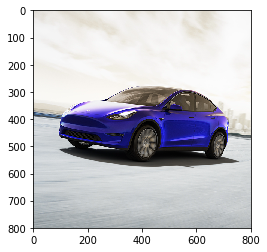

In [23]:
import cv2
import matplotlib.pyplot as plt

filename = 'model_y.png'
image = cv2.imread(filename)

plt.imshow(image)


In [24]:
image_t = torch.tensor(image)

In [26]:
image_t =image_t.reshape(3, 800, 800)

In [27]:
image_t.shape

torch.Size([3, 800, 800])

In [28]:
image_t.size(1)

800

In [14]:
import random

In [29]:
original_h = image_t.size(1)
original_w = image_t.size(2)
max_scale = 4
scale = random.uniform(1, max_scale)
new_h = int(scale * original_h)
new_w = int(scale * original_h)

In [30]:
filler = [100, 200, 150]

In [31]:
filler = torch.FloatTensor(filler)  # (3)
new_image = torch.ones((3, new_h, new_w), dtype=torch.float) * filler.unsqueeze(1).unsqueeze(1)


left = random.randint(0, new_w - original_w)
right = left + original_w
top = random.randint(0, new_h - original_h)
bottom = top + original_h
new_image[:, top:bottom, left:right] = image_t

    
    

In [35]:
new_image.shape


torch.Size([3, 2051, 2051])

In [36]:
new_pic = new_image.reshape(2051, 2051, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


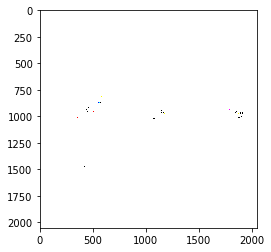

In [37]:
plt.imshow(new_pic)

In [19]:
new_image.shape

torch.Size([3, 976, 976])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


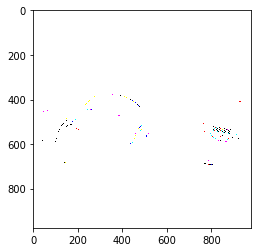

In [34]:
plt.imshow(new)

## Flip function exploration

In [62]:
boxes = torch.tensor([[2, 8, 2, 4],
        [50, 80, 50, 40],
        [5, 3, 2, 2]])


In [58]:
new_boxes = boxes

In [63]:
boxes[:, 0]

tensor([ 2, 50,  5])

In [64]:
boxes[:, 2]

tensor([ 2, 50,  2])

In [59]:
new_boxes[:, 0] = 100 - boxes[:, 0] - 1
new_boxes[:, 2] = 100 - boxes[:, 2]- 1
new_boxes = new_boxes[:, [2, 1, 0, 3]]

In [60]:
new_boxes

tensor([[97,  8, 97,  4],
        [49, 80, 49, 40],
        [97,  3, 94,  2]])